## Calculate emission spectrum with/without various absorbers

### Import system packages

In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

### Setup AGNI

In [2]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [3]:
gases = ["H2O", "H2", "CO2", "CO", "CH4", "N2", "NH3", "SO2", "N2O", "O3", "O2", "H2S"]

12-element Vector{String}:
 "H2O"
 "H2"
 "CO2"
 "CO"
 "CH4"
 "N2"
 "NH3"
 "SO2"
 "N2O"
 "O3"
 "O2"
 "H2S"

In [4]:
mole_fractions = Dict{String, Float64}()

for g in gases
    mole_fractions[g] = 0.1 
end 

In [5]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.energy as energy
import AGNI.dump as dump
import AGNI.plotting as plotting
import AGNI.setpt as setpt

# Disable logging from AGNI module
AGNI.setup_logging("",1)

[ Info: Precompiling AGNI [ede838c1-9ec3-4ebe-8ae8-da4091b3f21c]


In [6]:
# Configuration options
instellation    = 1e4   # Stellar flux [W m-2]
gravity         = 9.81
s0_fact         = 0.375  
zenith_degrees  = 48.19 
albedo_b        = 0.0
radius          = 6.37e6   
nlev_centre     = 100
p_surf          = 300.0         # bar
p_top           = 1e-6      # bar 
tmp_surf        = 3000.0
thermo          = true
overlap_method  = 2

spectral_file = joinpath(ROOT_DIR,"res/spectral_files/nogit/Honeyside/256/Honeyside.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/Users/nichollsh/Projects/AGNI/out/"

In [7]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [8]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        flag_rayleigh=false,
                        thermo_functions=thermo,
                        overlap_method=overlap_method
                        )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Inserting stellar spectrum 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 H2S     8.33e-02  
[ INFO  ]       2 SO2     8.33e-02  
[ INFO  ]       3 N2      8.33e-02  
[ INFO  ]       4 O3      8.33e-02  
[ INFO  ]       5 NH3     8.33e-02  
[ INFO  ]       6 O2      8.33e-02 (NO_OPACITY) 
[ INFO  ]       7 CO      8.33e-02  
[ INFO  ]       8 N2O     8.33e-02  
[ INFO  ]       9 CO2     8.33e-02  
[ INFO  ]      10 CH4     8.33e-02  
[ INFO  ]      11 H2O     8.33e-02  
[ INFO  ]      12 H2      8.33e-02  


In [9]:
setpt.dry_adiabat!(atmos)
atmosphere.calc_layer_props!(atmos)

true

### Do radtrans with different absorbers REMOVED from atmosphere

In [10]:
atm_arr = atmosphere.Atmos_t[]

for (i,g) in enumerate(gases)
    @printf("Running model for gas = %s \n",g)

    # set all to value
    for gg in gases 
        fill!(atmos.gas_vmr[gg], mole_fractions[gg])
    end

    # set this gas to zero
    fill!(atmos.gas_vmr[g], 0.0)

    # for gg in gases
    #     @printf("    %s  %.2e \n", gg, atmos.gas_vmr[gg][2])
    # end

    fill!(atmos.band_u_lw, 0.0)
    fill!(atmos.band_u_sw, 0.0)

    # do radtrans 
    energy.radtrans!(atmos, true)   # LW 
    energy.radtrans!(atmos, false)  # SW
    
    # Store result
    push!(atm_arr, deepcopy(atmos))

    @printf("--------------------------------- \n")
end 

@printf("Running model for all gases \n")
for g in gases 
    fill!(atmos.gas_vmr[g],  mole_fractions[g])
end
energy.radtrans!(atmos, true)   # LW 
energy.radtrans!(atmos, false)  # SW
push!(atm_arr, deepcopy(atmos))

println("Done!")

Running model for gas = H2O 
--------------------------------- 
Running model for gas = H2 
--------------------------------- 
Running model for gas = CO2 
--------------------------------- 
Running model for gas = CO 
--------------------------------- 
Running model for gas = CH4 
--------------------------------- 
Running model for gas = N2 
--------------------------------- 
Running model for gas = NH3 
--------------------------------- 
Running model for gas = SO2 
--------------------------------- 
Running model for gas = N2O 
--------------------------------- 
Running model for gas = O3 
--------------------------------- 
Running model for gas = O2 
--------------------------------- 
Running model for gas = H2S 
--------------------------------- 
Running model for all gases 
Done!


In [11]:
# for (i, atm) in enumerate(atm_arr)
#     dump.write_ncdf(atm, joinpath(atm.OUT_DIR, "$i.nc"))
# end

2

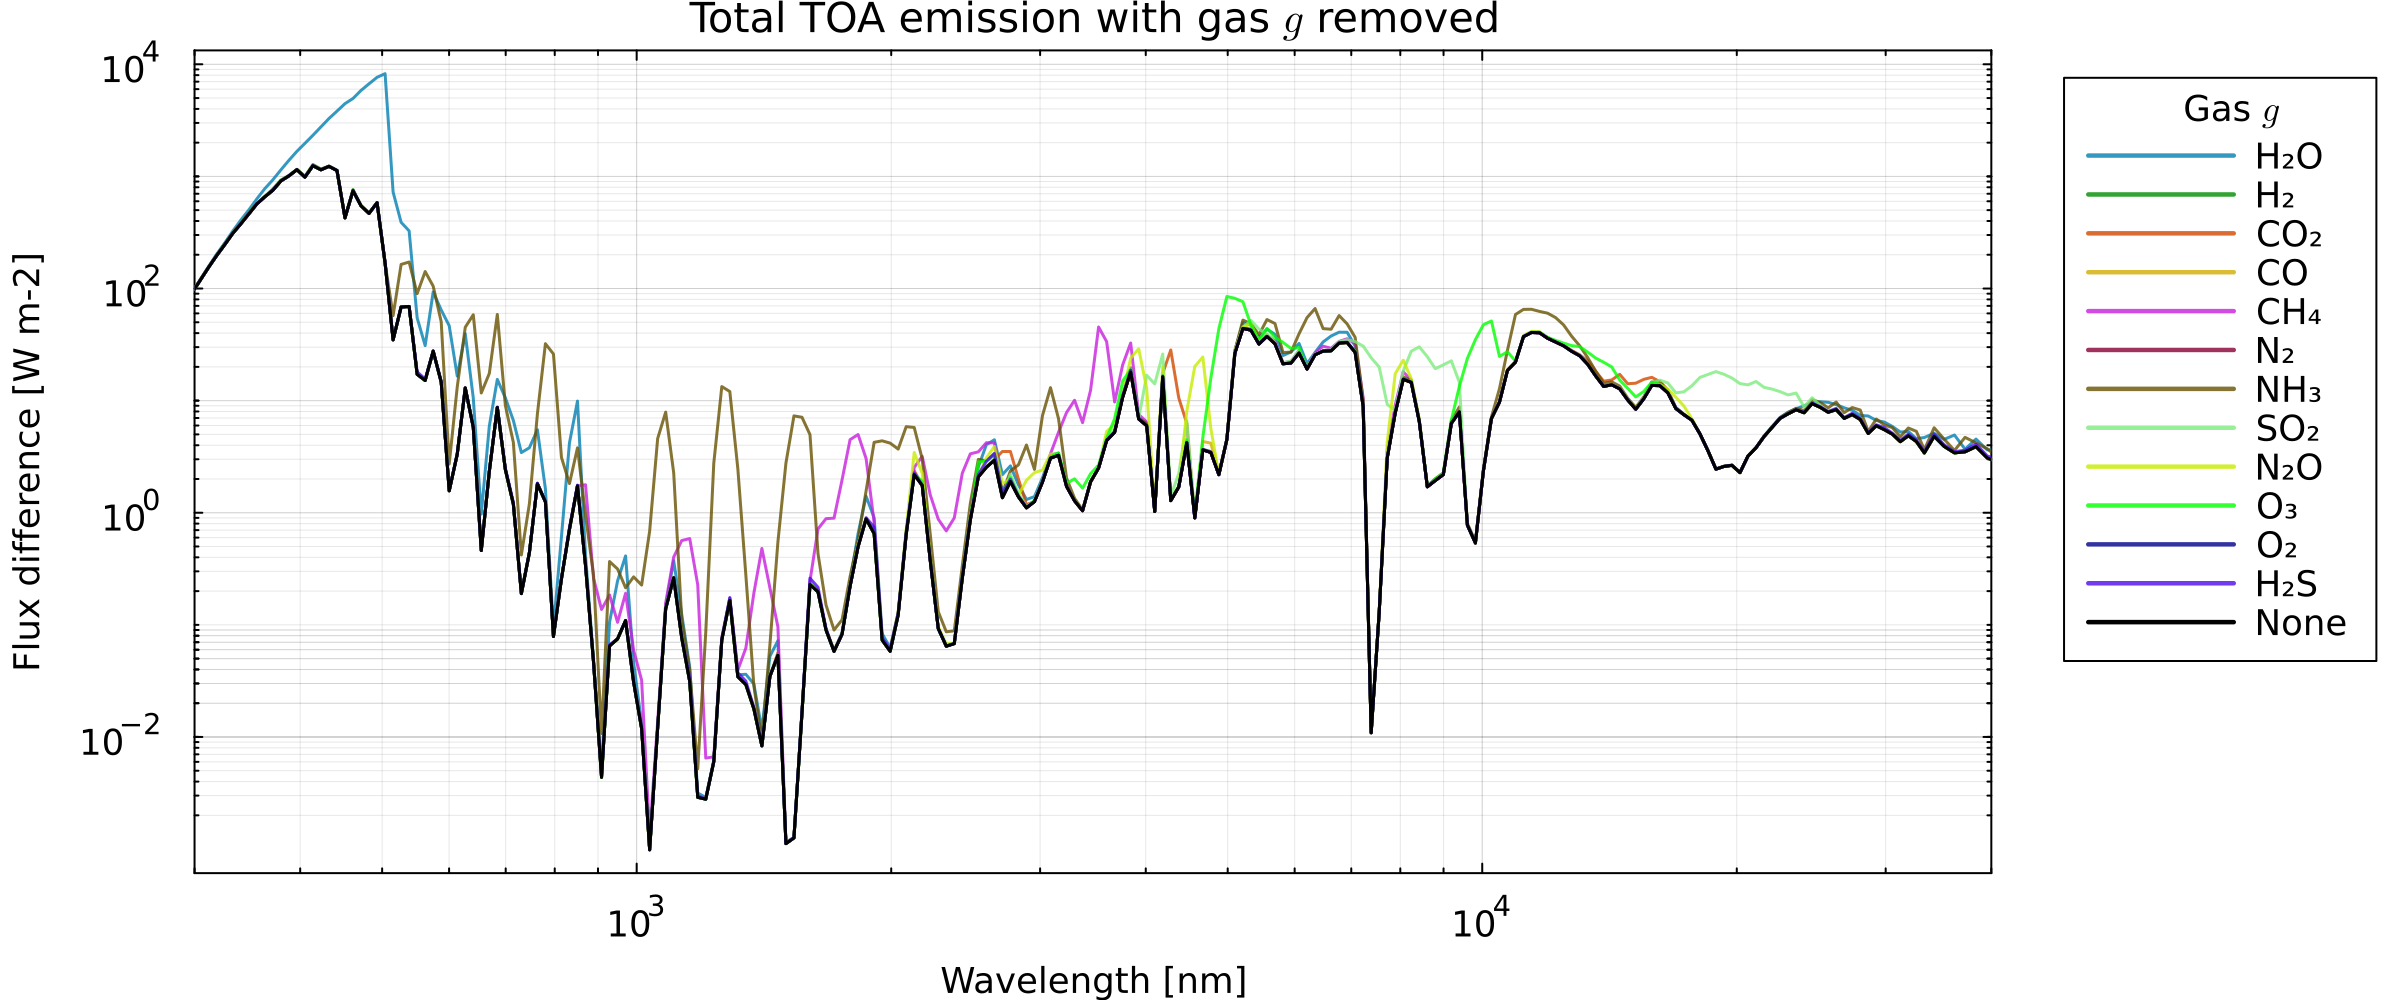

"/Users/nichollsh/Projects/AGNI/out/emission.pdf"

In [34]:
fs=12
lw=1.5
la=0.8
xlim = (3e2, 4e4)

display(atm_arr[1].overlap_method)

plt = plot(framestyle=:box, size=(1200,500), dpi=200, 
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs, 
                legendtitlefontsize=fs, leg_title=L"Gas $g$",
                left_margin = 6Plots.mm,
                bottom_margin = 6Plots.mm,
                title=L"Total TOA emission with gas $g$ removed")
          


# for each gas
for i in 1:length(gases)

    this_atm = atm_arr[i]
    x_arr = 0.5 * 1e9 * (this_atm.bands_max + this_atm.bands_max)
    y_arr = this_atm.band_u_lw[1,:] + this_atm.band_u_sw[1,:]

    lbl = this_atm.gas_dat[gases[i]].plot_label
    col = this_atm.gas_dat[gases[i]].plot_color

    plot!(plt, x_arr, y_arr, linewidth=lw, label=lbl, linealpha=la, linecolor=col)
end 

# all gases
this_atm = atm_arr[end]
x_tot = 0.5 * 1e9 * (this_atm.bands_max + this_atm.bands_max)
y_tot = this_atm.band_u_lw[1,:] + this_atm.band_u_sw[1,:]
plot!(plt, x_tot, y_tot, linewidth=lw, label="None", linestyle=:solid, linecolor="black",)


xlabel!(plt, "Wavelength [nm]")
xaxis!(plt, minorgrid=true, xlims=xlim, xscale=:log10)
ylabel!(plt, "Flux difference [W m-2]")
yaxis!(plt, yscale=:log10)

display(plt)
savefig(plt,joinpath(output_dir,"emission.pdf"))